# Reducing a set of orders and cross-correlating

In [1]:
#------ manually fix import for now
import sys
sys.path.append('../src/')
#------

import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from redcross.read import read_harpsn
from redcross.datacube import Datacube
from redcross.cross_correlation import CCF, KpV, Template
from redcross.planet import Planet

%load_ext autoreload
%autoreload 2

## Read dataset of `e2ds` files (HARPS-N) or load pre-read `datacube`
The function reads a set of `M` frames with `N` orders each, with flux values for each wavelength channel `C`
and returns a reshaped `datacube` with shape `(N,M,C)`. After the first run, we can save the datacube instance and load it again with its in-build functions (fast).

In [2]:
night = '2'
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/e2ds/night{:}/'.format(night)

read_from_files = False # set to `True` the first time running it

if read_from_files:
    files = sorted(glob.glob(data_dir+'*.fits')) # select files
    dc = read_harpsn(files, 'e2ds')
    dc.save(data_dir+'datacube_input.npy')
else:
    dc = Datacube().load(data_dir+'datacube_input.npy')

Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp189/data/e2ds/night2/datacube_input.npy


### Load template and planet object
Similarly to previous examples...

In [3]:
template_path = 'data/wasp189_fe_4000k.fits'
with fits.open(template_path) as hdul:
    hdul.info()
    twave = hdul[0].data
    tflux = hdul[1].data
# flux must be continuum subtracted (normalised)
template = Template(wlt=twave, flux=tflux)

planet = Planet('wasp189')
planet.BERV = dc.BERV
planet.MJD = dc.MJD

Filename: data/wasp189_fe_4000k.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   (72646,)   float64   
  1                1 ImageHDU         6   (72646,)   float64   


### Define reduction routine
Create a function that applies a set of reduction steps to *each order*. Then we call the `reduce_orders` function to apply the reduction routine to all orders (parallelised). The output datacube is a copy, the ol

In [4]:
def my_reduction(dco=None):
    dco.wlt = np.median(dco.wlt, axis=0)
    dco.normalise().airmass_detrend().sysrem(2).high_pass_gaussian(15)
    return dco

# datacube reduced 
orders = np.arange(48,53)

dc_in = dc.mask_eclipse(planet, invert_mask=True).reduce_orders(my_reduction, orders, num_cpus=2)
dc_out = dc.mask_eclipse(planet).reduce_orders(my_reduction, orders, num_cpus=2)


    


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
dc_in.shape

(102, 20480)

In [12]:
dRV = 1.0
RVt = np.arange(-350,351, dRV)

ccf_in = CCF(rv=RVt, template=template).run(dc_in, weighted=True)
ccf_out = CCF(rv=RVt, template=template).run(dc_out, weighted=True)

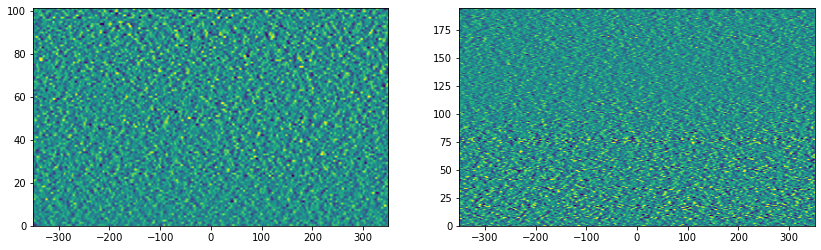

In [13]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
ccf_in.imshow(ax=ax[0])
ccf_out.imshow(ax=ax[1])
plt.show()

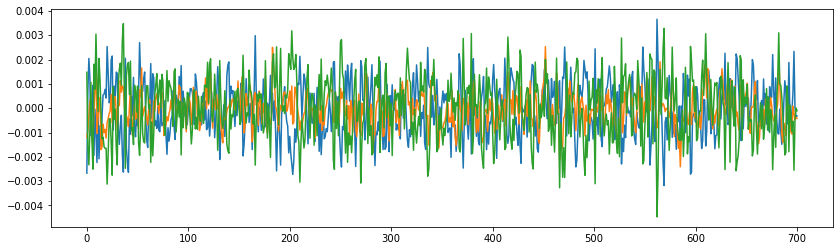

In [14]:
fig, ax = plt.subplots(1,figsize=(14,4))
ax.plot(np.median(ccf_in.flux, axis=0))
ax.plot(np.median(ccf_out.flux, axis=0))
ax.plot(np.median(ccf_out.flux, axis=0) - np.median(ccf_in.flux, axis=0))
plt.show()

Horizontal slice at Kp = 220.5 km/s
Vertical slice at Vrest = -48.0 km/s


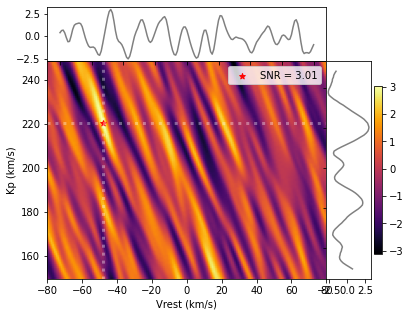

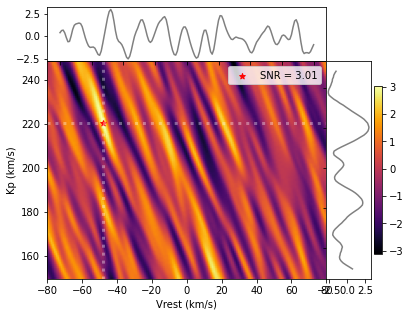

In [18]:
noise = np.median(ccf_in.flux, axis=0)
ccf_out.flux -= noise
kpv_out = KpV(ccf_out, planet_out, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.).run()
kpv_out.fancy_figure(snr_max=True)


Horizontal slice at Kp = 248.5 km/s
Vertical slice at Vrest = 44.0 km/s
Horizontal slice at Kp = 225.5 km/s
Vertical slice at Vrest = -50.0 km/s


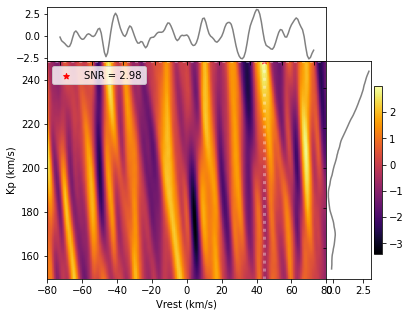

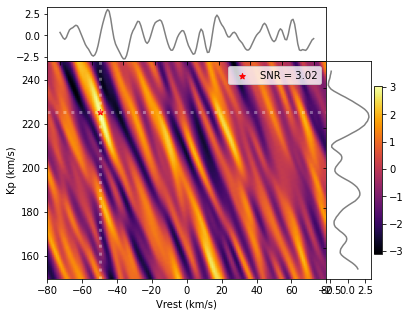

In [16]:
planet_in = Planet('wasp189', **dc.get_header().header).mask_eclipse(invert_mask=True)
planet_out = Planet('wasp189', **dc.get_header().header).mask_eclipse(invert_mask=False)

dkp, kp_amp = dRV, 50 # km/s
vrest_amp, dvrest = 80, dRV # km /s


kpv_in = KpV(ccf_in, planet_in, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.).run()
kpv_in.fancy_figure(snr_max=True)


kpv_out = KpV(ccf_out, planet_out, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.).run()
kpv_out.fancy_figure(snr_max=True)

plt.show()

Horizontal slice at Kp = 183.5 km/s
Vertical slice at Vrest = 4.0 km/s


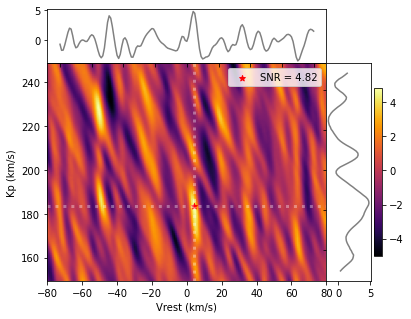

In [17]:
kpv = kpv_out.copy()
kpv.snr -= kpv_in.snr

kpv.fancy_figure(snr_max=True)
plt.show()